# Advection-diffusion-reaction equations #

The problems we have encountered so far---with the notable exception
of the Navier-Stokes equations---all share a common feature: they all
involve models expressed by a *single* scalar or vector PDE. In many
situations the model is instead expressed as a system of PDEs,
describing different quantities possibly governed by (very) different
physics. As we saw for the Navier-Stokes equations, one way to solve
a system of PDEs in FEniCS is to use a splitting method where we solve
one equation at a time and feed the solution from one equation into
the next. However, one of the strengths with FEniCS is the ease by
which one can instead define variational problems that couple several
PDEs into one compound system. In this section, we will look at how to use
FEniCS to write solvers for such systems of coupled PDEs.
The goal is to demonstrate how easy it is to implement fully implicit,
also known as monolithic, solvers in FEniCS.

## PDE problem ##

Our model problem is the following system of
advection-diffusion-reaction equations:
\begin{align}
  \label{ftut1-reactionsystem-system-1}
  \frac{\partial u_1}{\partial t} +
  \boldsymbol{w} \cdot \boldsymbol{\nabla} u_1 - \boldsymbol{\nabla}\cdot(\epsilon\boldsymbol{\nabla} u_1)
    &= f_1 -K u_1 u_2, \\
  \label{ftut1-reactionsystem-system-2}
  \frac{\partial u_2}{\partial t} +
  \boldsymbol{w} \cdot \boldsymbol{\nabla} u_2 - \boldsymbol{\nabla}\cdot(\epsilon\boldsymbol{\nabla} u_2)
    &= f_2 -K u_1 u_2, \\
  \label{ftut1-reactionsystem-system-3}
  \frac{\partial u_3}{\partial t} +
  \boldsymbol{w} \cdot \boldsymbol{\nabla} u_3 - \boldsymbol{\nabla}\cdot(\epsilon\boldsymbol{\nabla} u_3)
    &= f_3 + K u_1 u_2 - K u_3.
\end{align}

This system models the chemical reaction between two species $A$ and
$B$ in some domain $\Omega$:

\[
  A + B \rightarrow C.
\]

The variables $u_1$, $u_2$, and $u_3$ denote the
concentrations of the three species:
\[
  u_1 = [A], \quad u_2 = [B], \quad u_3 = [C].
\]
The $f_i$ are the source terms of the three species.

The chemical reactions are accounted for in the
right-hand sides of the PDE system (\ref{ftut1-reactionsystem-system-1})-(\ref{ftut1-reactionsystem-system-3}). We assume that the reaction is *first-order*, meaning that the
reaction rate is proportional to the concentrations $[A]$ and $[B]$ of
the two species $A$ and $B$:

\[
  \frac{\mathrm{d}}{\mathrm{d}t} [C] = K [A] [B].
\]

We also assume that the formed species $C$ spontaneously decays with a
rate proportional to the concentration $[C]$. 

The chemical reactions take part at each point in the domain
$\Omega$. In addition, we assume that the species $A$, $B$, and $C$
diffuse throughout the domain with diffusivity $\epsilon$ (the terms
$-\boldsymbol{\nabla}\cdot(\epsilon\boldsymbol{\nabla} u_i)$) and are advected with velocity
$\boldsymbol{w}$ (the terms $\boldsymbol{w}\cdot\boldsymbol{\nabla} u_i$).

To make things visually and physically interesting, we shall let the
chemical reaction take place in the velocity field computed from the
solution of the incompressible Navier-Stokes equations around a
cylinder. In summary, we will thus be
solving the following coupled system of nonlinear PDEs:

\begin{align}
  \label{ftut1-reactionsystem-full}
  \varrho\left(\frac{\partial \boldsymbol{w}}{\partial t} +
      \boldsymbol{w} \cdot \boldsymbol{\nabla} \boldsymbol{w}\right) &= \boldsymbol{\nabla}\cdot\boldsymbol{\sigma}(\boldsymbol{w}, p) + \boldsymbol{f}, \\
  \boldsymbol{\nabla} \cdot \boldsymbol{w} &= 0, \\
  \frac{\partial u_1}{\partial t} +
  \boldsymbol{w} \cdot \boldsymbol{\nabla} u_1 - \boldsymbol{\nabla}\cdot(\epsilon\boldsymbol{\nabla} u_1)
    &= f_1 - K u_1 u_2, \\
  \frac{\partial u_2}{\partial t} +
  \boldsymbol{w} \cdot \boldsymbol{\nabla} u_2 - \boldsymbol{\nabla}\cdot(\epsilon\boldsymbol{\nabla} u_2)
    &= f_2 - K u_1 u_2, \\
  \frac{\partial u_3}{\partial t} +
  \boldsymbol{w} \cdot \boldsymbol{\nabla} u_3 - \boldsymbol{\nabla}\cdot(\epsilon\boldsymbol{\nabla} u_3)
    &= f_3 + K u_1 u_2 - K u_3.
\end{align}

This system is one-way coupled from the Navier--Stokes subsystem
to the advection-diffusion-reaction subsystem.

We assume that $u_1 = u_2 = u_3 = 0$ at $t = 0$ and inject the species
$A$ and $B$ into the system by specifying nonzero source terms $f_1$
and $f_2$ close to the corners at the inflow, and take $f_3 = 0$. The
result will be that $A$ and $B$ are convected by advection and
diffusion throughout the channel, and when they mix the species $C$
will be formed.

## Variational formulation ##

We obtain the variational formulation of our system by multiplying
each equation by a test function, integrating the second-order terms
$-\boldsymbol{\nabla}\cdot(\epsilon\boldsymbol{\nabla} u_i)$ by parts, and summing up the
equations. When working with FEniCS it is convenient to think of the
PDE system as a vector of equations. The test functions are collected in
a vector too, and the variational formulation is the inner product of
the vector PDE and the vector test function.

We also need introduce some discretization in time. We will use the
backward Euler method as before when we solved the heat equation and
approximate the time derivatives by $(u_i^{n+1}-u_i^n) / \delta t$. Let
$v_1$, $v_2$, and $v_3$ be the test functions, or the components of
the test vector function. The inner product results in
\begin{align}
  \label{ftut1-reactionsystem-varproblem}
  & \int_{\Omega}
  (\delta t^{-1} (u_1^{n+1} - u_1^n) v_1 + \boldsymbol{w} \cdot \boldsymbol{\nabla} u^{n+1}_1 \, v_1
  + \epsilon \boldsymbol{\nabla} u^{n+1}_1 \cdot \boldsymbol{\nabla} v_1) \rm{d}\boldsymbol{x} \\
  + & \int_{\Omega} (\delta t^{-1} (u_2^{n+1} - u_2^n) v_2
  + \boldsymbol{w} \cdot \boldsymbol{\nabla} u^{n+1}_2 \, v_2
  + \epsilon \boldsymbol{\nabla} u^{n+1}_2 \cdot \boldsymbol{\nabla} v_2) \rm{d}\boldsymbol{x} \nonumber \\
  + & \int_{\Omega} (\delta t^{-1} (u_3^{n+1} - u_3^n) v_3
  + \boldsymbol{w} \cdot \boldsymbol{\nabla} u^{n+1}_3 \, v_3
  + \epsilon \boldsymbol{\nabla} u^{n+1}_3 \cdot \boldsymbol{\nabla} v_3) \rm{d}\boldsymbol{x} \nonumber \\
  - & \int_{\Omega} (f_1 v_1 + f_2 v_2 + f_3 v_3) \rm{d}\boldsymbol{x} \nonumber \\
  - & \int_{\Omega} (-K u^{n+1}_1 u^{n+1}_2 v_1 - K u^{n+1}_1
  u^{n+1}_2 v_2 + K u^{n+1}_1 u^{n+1}_2 v_3 - K u^{n+1}_3 v_3) \rm{d}\boldsymbol{x} = 0.
  \nonumber
\end{align}

For this problem it is natural to assume homogeneous Neumann boundary
conditions on the entire boundary for $u_1$, $u_2$, and $u_3$; that
is, $\partial u_i/\partial n = 0$ for $i = 1, 2, 3$. This means that
the boundary terms vanish when we integrate by parts.

## FEniCS implementation ##

The first step is to read the mesh from file. If you have written out the mesh previously, you can read it in using the following statement:
```
mesh = Mesh('navier_stokes_cylinder/cylinder.xml.gz')
```
The mesh is stored in the native FEniCS XML format (with additional
gzipping to decrease the file size).

Here, we will generate the mesh from scratch. 

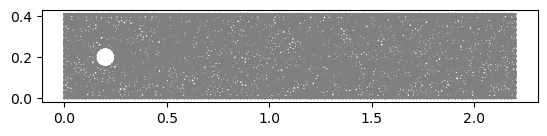

In [1]:
from fenics import *
# %matplotlib inline

# from mshr import *

# channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
# cylinder = Circle(Point(0.2, 0.2), 0.05, 16)
# domain = channel - cylinder

# mesh = generate_mesh(domain, 64)
mesh = Mesh()
xdmf_file = XDMFFile("./mesh.xdmf")
xdmf_file.read(mesh)
plot(mesh)

Next, we need to define the finite element function space. For this
problem, we need to define several spaces. The first space we create
is the space for the velocity field $w$ from the Navier--Stokes
simulation. We call this space $W$ and define the space by

In [2]:
# Define function space for velocity
W = VectorFunctionSpace(mesh, 'P', 2)

It is important that this space is exactly the same as the space we
used for the velocity field in the Navier-Stokes solver. 

For the three concentrations $u_1$, $u_2$, and $u_3$, we want to
create a *mixed space* using `MixedElement` with three scalar functions representing the full system $(u_1, u_2, u_3)$ as a single entity.

In [3]:
# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

**Note**: We can also define the mixed finite elements with:
```
element = VectorElement('P', triangle, 1, dim=3)
V = FunctionSpace(mesh, element)
```

Note that for Navier-Stoke's equation, we used the product of elements to define the mixed Taylor-Hood element:
```
P2 = VectorElement('P', triangle, 2)
P1 = FiniteElement('P', triangle, 1)
TH = P2 * P1
```
However, this syntax does not work well with three or more elements because `element = P1 * P1 * P1` is interpreted as `element = (P1 * P1) * P1`, and the mixed element would be consisting of two subsystems.

Once the space has been created, we need to define our test functions
and finite element functions. Test functions for a mixed function
space can be created by replacing `TestFunction` by `TestFunctions`:

In [4]:
# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

Since the problem is nonlinear, we need to work with functions rather
than trial functions for the unknowns. This can be done by using the
corresponding `Functions` construction in FEniCS. However, as we will
need to access the `Function` for the entire system itself, we first
need to create that function and then access its components:

In [5]:
# Define functions for velocity and concentrations
w = Function(W)
# w = Constant((1,0))
u = Function(V)
u_n = Function(V)

# Split system functions to access components
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)

These functions will be used to represent the unknowns $u_1$, $u_2$, and $u_3$
at the new time level $n+1$. The corresponding values at the previous
time level $n$ are denoted by `u_n1`, `u_n2`, and `u_n3` in our program.

In [6]:
# Define source terms
f_1 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.1,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_2 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.3,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_3 = Constant(0)

We now define some parameters and expressions used in variational forms.

In [7]:
T = 0.5            # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
eps = 0.01         # diffusion coefficient
K = 10.0           # reaction rate

# Define expressions used in variational forms
k = Constant(dt)
K = Constant(K)
eps = Constant(eps)

Now all functions and test functions have been defined. We can
express the nonlinear variational problem
(\ref{ftut1-reactionsystem-varproblem}):

In [8]:
F = ((u_1 - u_n1) / k)*v_1*dx + dot(w, grad(u_1))*v_1*dx \
  + eps*dot(grad(u_1), grad(v_1))*dx + K*u_1*u_2*v_1*dx  \
  + ((u_2 - u_n2) / k)*v_2*dx + dot(w, grad(u_2))*v_2*dx \
  + eps*dot(grad(u_2), grad(v_2))*dx + K*u_1*u_2*v_2*dx  \
  + ((u_3 - u_n3) / k)*v_3*dx + dot(w, grad(u_3))*v_3*dx \
  + eps*dot(grad(u_3), grad(v_3))*dx - K*u_1*u_2*v_3*dx + K*u_3*v_3*dx \
  - f_1*v_1*dx - f_2*v_2*dx - f_3*v_3*dx

One could write out the velocity field into a `TimeSeries` and then read it back in, such as 
```
timeseries_w = TimeSeries('navier_stokes_cylinder/velocity_series')
```
However, file I/O is too expensive compared to computation. Hence, we solve the Navier-Stokes equation directly.

To avoid name conflicts between the Navier-Stokes solver and the advection-diffusion-reaction solver, we encapsulate the Navier-Stokes solver into a class.

In [9]:
vtkfile_u = File('ns_system/u.pvd')
vtkfile_p = File('ns_system/p.pvd')


In [10]:
class NavierStokesSolver:
    # Define function spaces
    inflow   = 'near(x[0], 0)'
    outflow  = 'near(x[0], 2.2)'
    walls    = 'near(x[1], 0) || near(x[1], 0.41)'
    cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

    # Define inflow profile
    inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

    mu = 0.001         # dynamic viscosity
    rho = 1            # density

    f  = Constant((0, 0))
    mu = Constant(mu)

    def epsilon(u):
        return sym(nabla_grad(u))

    # Define stress tensor
    def sigma(self, u, p):
        return 2*self.mu*NavierStokesSolver.epsilon(u) - p*Identity(len(u))

    # Define symmetric gradient
    def __init__(self, mesh, dt):
        self.V = VectorFunctionSpace(mesh, 'P', 2)
        self.Q = FunctionSpace(mesh, 'P', 1)

        # Define boundary conditions
        bcu_inflow = DirichletBC(self.V, Expression(self.inflow_profile, degree=2), self.inflow)
        bcu_walls = DirichletBC(self.V, Constant((0, 0)), self.walls)
        bcu_cylinder = DirichletBC(self.V, Constant((0, 0)), self.cylinder)
        bcp_outflow = DirichletBC(self.Q, Constant(0), self.outflow)
        self.bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
        self.bcp = [bcp_outflow]

        # Define trial and test functions
        self.v = TestFunction(self.V)
        self.q = TestFunction(self.Q)

        self.u = TrialFunction(self.V)
        self.p = TrialFunction(self.Q)

        # Define functions for solutions at previous and current time steps
        self.u_k = Function(self.V)
        self.u_  = Function(self.V)

        self.p_k = Function(self.Q)
        self.p_  = Function(self.Q)

        # Define expressions used in variational forms
        self.DT = Constant(dt)

        self.u_mid  = 0.5*(self.u_k + self.u)
        self.n  = FacetNormal(mesh)

        # Define variational problem for step 1
        self.F1 = self.rho*dot((self.u - self.u_k) / self.DT, self.v)*dx \
           + self.rho*dot(dot(self.u_k, nabla_grad(self.u_k)), self.v)*dx \
           + inner(self.sigma(self.u_mid, self.p_k), NavierStokesSolver.epsilon(self.v))*dx \
           + dot(self.p_k*self.n, self.v)*ds - dot(self.mu*nabla_grad(self.u_mid)*self.n, self.v)*ds \
           - dot(self.f, self.v)*dx

        self.a1 = lhs(self.F1)
        self.L1 = rhs(self.F1)
        self.A1 = assemble(self.a1)
        [bc.apply(self.A1) for bc in self.bcu]

        # Define variational problem for step 2
        self.a2 = dot(nabla_grad(self.p), nabla_grad(self.q))*dx
        self.L2 = dot(nabla_grad(self.p_k), nabla_grad(self.q))*dx - (1/self.DT)*div(self.u_)*self.q*dx
        self.A2 = assemble(self.a2)
        [bc.apply(self.A2) for bc in self.bcp]

        # Define variational problem for step 3
        self.a3 = dot(self.u, self.v)*dx
        self.L3 = dot(self.u_, self.v)*dx - self.DT*dot(nabla_grad(self.p_ - self.p_k), self.v)*dx
        self.A3 = assemble(self.a3)
        
    def advance(self,t):
        # Update current time
        # Step 1: Tentative velocity step
        b1 = assemble(self.L1)
        [bc.apply(b1) for bc in self.bcu]
        solve(self.A1, self.u_.vector(), b1, 'bicgstab', 'ilu')

        # Step 2: Pressure correction step
        b2 = assemble(self.L2)
        [bc.apply(b2) for bc in self.bcp]
        solve(self.A2, self.p_.vector(), b2, 'bicgstab', 'ilu')

        # Step 3: Velocity correction step
        b3 = assemble(self.L3)
        solve(self.A3, self.u_.vector(), b3, 'cg', 'sor')
        
        # Update previous solution
        self.u_k.assign(self.u_)
        self.p_k.assign(self.p_)
        
        vtkfile_u << (self.u_, t)
        vtkfile_p << (self.p_, t)

In [11]:
# Create VTK files for visualization output
vtkfile_u_1 = File('reaction_system/u_1.pvd')
vtkfile_u_2 = File('reaction_system/u_2.pvd')
vtkfile_u_3 = File('reaction_system/u_3.pvd')

# Create progress bar
progress = Progress('Time-stepping',num_steps)
set_log_level(LogLevel.PROGRESS)

The time-stepping simply consists of solving this variational problem
in each time step by a call to the `solve` function.
In each time step, we first read the current value for the velocity
field from the time series we have previously stored. We then solve
the nonlinear system, and assign the computed values to the left-hand
side values for the next time interval. When retrieving values from a
`TimeSeries`, the values will by default be interpolated (linearly) to
the given time `t` if the time does not exactly match a sample in the
series.

In [12]:
# Time-stepping
t = 0
out_interval = num_steps / 100;

nss = NavierStokesSolver(mesh, dt)

for k in range(num_steps):
    # Update current time
    t += dt

    # Advance the Navier-Stokes solver in time
    nss.advance(t)

    # Copy velocities from Navier-Stokes solver to a-d-r solver
    w.assign(nss.u_k)

    # Solve variational problem for time step
    solve(F == 0, u)

    if k%out_interval ==0 or k==num_steps:
        # Save solution to file (VTK)
        _u_1, _u_2, _u_3 = u.split()
        vtkfile_u_1 << (_u_1, t)
        vtkfile_u_2 << (_u_2, t)
        vtkfile_u_3 << (_u_3, t)

        # print('u max: ', u.vector().array().max())
        
    # Update previous solution
    u_n.assign(u)

    # Update progress bar
    # progress.update(t / T)
    set_log_level(LogLevel.PROGRESS)
    progress += 1
    set_log_level(LogLevel.PROGRESS)
    

Applying boundary conditions to linear system.
Applying boundary conditions to linear system.
Applying boundary conditions to linear system.
Applying boundary conditions to linear system.
Applying boundary conditions to linear system.
Applying boundary conditions to linear system.
Applying boundary conditions to linear system.
PETSc Krylov solver starting to solve 18834 x 18834 system.
Applying boundary conditions to linear system.
PETSc Krylov solver starting to solve 2431 x 2431 system.
PETSc Krylov solver starting to solve 18834 x 18834 system.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.204e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Solving linear system of size 7293 x 7293 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 7293 x 7293 system.
  Newton iteration 1: r (abs) = 2.791e-16 (tol = 1.000e-

Finally, we comment on three important techniques that are very useful
when working with systems of PDEs: setting initial conditions, setting
boundary conditions, and extracting components of the system for
plotting or postprocessing.

## Setting initial conditions for mixed systems ##

In our example, we did not need to worry about setting an initial
condition, since we start with $u_1 = u_2 = u_3 = 0$. This happens
automatically in the code when we set `u_n = Function(V)`. This
creates a `Function` for the whole system and all degrees of freedom
are set to zero.

If we want to set initial conditions for the components of the system
separately, the easiest solution is to define the initial conditions
as a vector-valued `Expression` and then project (or interpolate) this
to the `Function` representing the whole system. For example,

```
u_0 = Expression(('sin(x[0])', 'cos(x[0]*x[1])', 'exp(x[1])'), degree=1)
u_n = project(u_0, V)
```
This defines $u_1$, $u_2$, and $u_2$ to be the projections of $\sin
x$, $\cos (xy)$, and $\exp(y)$, respectively.

## Setting boundary conditions for mixed systems ##

In our example, we also did not need to worry about setting boundary
conditions since we used a natural Neumann condition. If we want to set
Dirichlet conditions for individual components of the system, this can
be done as usual by the class `DirichletBC`, but we must specify for
which subsystem we set the boundary condition. For example, to specify
that $u_2$ should be equal to $xy$ on the boundary defined by
`boundary`, we do

```
u_D = Expression('x[0]*x[1]', degree=1)
bc = DirichletBC(V.sub(1), u_D, boundary)
```
The object `bc` or a list of such objects containing different
boundary conditions, can then be passed to the `solve` function as usual.
Note that numbering starts at $0$ in FEniCS so the subspace
corresponding to $u_2$ is `V.sub(1)`.

## Accessing components of mixed systems ##

If `u` is a `Function` defined on a mixed function space in FEniCS,
there are several ways in which `u` can be *split* into components.
Above we already saw an example of the first of these:

```
u_1, u_2, u_3 = split(u)
```
This extracts the components of `u` as *symbols* that can be used in a
variational problem. The above statement is in fact equivalent to

```
u_1 = u[0]
u_2 = u[1]
u_3 = u[2]
```
Note that `u[0]` is not really a `Function` object, but merely a
symbolic expression, just like `grad(u)` in FEniCS is a symbolic
expression and not a `Function` representing the gradient.  This means
that `u_1`, `u_2`, `u_3` can be used in a variational problem, but
cannot be used for plotting or postprocessing.

To access the components of `u` for plotting and saving the solution
to file, we need to use a different variant of the `split` function:

```
u_1_, u_2_, u_3_ = u.split()
```
This returns three subfunctions as actual objects with access to the
common underlying data stored in `u`, which makes plotting and saving
to file possible. Alternatively, we can do

```
u_1_, u_2_, u_3_ = u.split(deepcopy=True)
```
which will create `u_1_`, `u_2_`, and `u_3_` as stand-alone `Function`
objects, each holding a copy of the subfunction data extracted from
`u`. This is useful in many situations but is not necessary for
plotting and saving solutions to file.

**Acknowledgment**: This notebook was adapted from [The FEniCS Tutorial Volume I](https://fenicsproject.org/pub/tutorial/sphinx1/) by Hans Petter Langtangen and Anders Logg, released under CC Attribution 4.0 license.